## Test the relation between knowledge distribition and the NLL of ripple effect
* defination of knowledge distribution: 
    * A->B edit A:->+C -> change B -> ripple effect
    * distribution between A and C: if a and c are not so related, the ripple cannot map the change in A to problem C so can not do ripple 
    * ways to measure distribition: $cos_{llama32layers}(gradient(A), gradient(C))$ on original model
    * ways to detect ripple effect: the NLL of B on edited model

In [1]:
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(5)
from utils.all_imports import *
from utils.data_processing_utils import *


# # import model and test_data
# model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,5)
# hparams = ROMEHyperParams.from_name("llama-7b")
# template = Template(name="default")
# streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)
    

path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/over_all_cosine_results_q_rq50.json"
with open(path,"r") as json_file:
    inner_product_results = json.load(json_file)

In [ ]:
inner_product_results = []
for one_data in tqdm(test_data[16:]):
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
    
    # calculate the inner product between the gradient of the original sentence and the gradient of conditional sentence
    for query in one_data['compositional_I_problems']:
        one_data_results = dict() # initialize
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            inner_product = inner_product_between_contexts(model,tokenizer,query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer,model_device=6,plot=True)
            one_data_results['inner_product'] = inner_product
        print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            one_data_results['edited_sentence'] = edited_sentence
            one_data_results['edited_sentence_answer'] = edited_sentence_answer
            one_data_results['ripple_sentence'] = query['compositional_query']['prompt']
            one_data_results['ripple_sentence_answer'] = query['compositional_query']['answer']
            one_data_results['condition_query'] = query['condition_query']['prompt']
            one_data_results['condition_query_answer'] = query['condition_query']['answer']
            
            result = calculate_min_probability(model_edited,tokenizer,one_data_results['ripple_sentence'],[one_data_results['ripple_sentence_answer']],space_n=10)
        one_data_results['NLL'] = result
        inner_product_results.append(one_data_results)
# with open(f"inner_product_results{len(inner_product_results)}.json","w") as json_file:
#     json.dump(inner_product_results,json_file)

In [ ]:
for one_example in inner_product_results:
    mlp_down_project = [one_example['inner_product'][i] for i in one_example['inner_product'] if 'o_proj' in i]
    plt.figure(figsize=(12,3))
    plt.plot(mlp_down_project)
    plt.grid(True)
    plt.title(f"NLL:{min(one_example['NLL'])}")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
names = [i for i in inner_product_results[0]['inner_product']]
for name in names:
    a = [one['inner_product'][name] for one in inner_product_results]
    y = [min(one['NLL']) for one in inner_product_results]
    plt.figure(figsize=(3,3))
    plt.scatter(y,a,s=1)
    plt.grid(True)
    plt.title(f"{name}")
    # plt.show()
    plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/plots/{name}.png")

## calculate all the cosine

In [4]:
one_data = test_data[0]
one_data

{'edit': {'prompt': 'The name of the country of citizenship of Leonardo DiCaprio is Syria.',
  'subject_id': 'Leonardo DiCaprio',
  'relation': 'COUNTRY_OF_CITIZENSHIP',
  'target_id': 'Syria',
  'original_fact': {'prompt': 'The name of the country of citizenship of Leonardo DiCaprio is United States of America.',
   'subject_id': 'Leonardo DiCaprio',
   'relation': 'COUNTRY_OF_CITIZENSHIP',
   'target_id': 'United States of America'}},
 'compositional_I_problems': [{'compositional_query': {'prompt': 'The name of the currency in the country of citizenship of Leonardo DiCaprio is',
    'answer': 'Syrian pound',
    'subject': 'Leonardo DiCaprio',
    'target': 'Syria',
    'relation': 'COUNTRY_OF_CITIZENSHIP'},
   'condition_query': {'prompt': 'The name of the currency in Syria is',
    'answer': 'Syrian pound',
    'subject': 'Syria',
    'target': 'Syrian pound',
    'relation': 'CURRENCY'}},
  {'compositional_query': {'prompt': 'The official language of the country of citizenship of 

In [5]:
context1 = "The name of the country of citizenship of Leonardo DiCaprio is"
target1 = "Syria"
context2 = "The name of the currency in the country of citizenship of Leonardo DiCaprio is"
target2 = "Syrian pound"

In [6]:
gradient1,loss1 = calculate_gradient(model,tokenizer,context1+" "+target1,target1,plot=False)
gradient2,loss2 = calculate_gradient(model,tokenizer,context2+" "+target2,target2,plot=False)

tensor(6.7008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4610, device='cuda:0', grad_fn=<NllLossBackward0>)


In [2]:
import json
import matplotlib.pyplot as plt
import torch
import numpy as np
import math
from scipy import stats
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(5)
from utils.all_imports import *
from utils.data_processing_utils import *

path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/over_all_cosine_results_fp6450-100.json"
with open(path,"r") as json_file:
    inner_product_results = json.load(json_file)

In [2]:
x = np.array([(one['cosine_value']) for one in inner_product_results])
y = np.array([min(one['NLL'])-min(one['orginal_NLL']) for one in inner_product_results])

Text(0.5, 1.0, 'cosine_value')

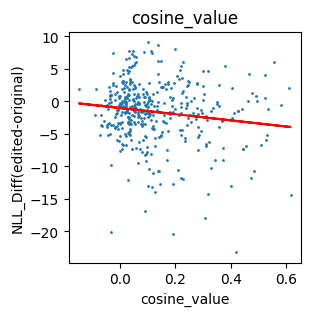

In [3]:
x = np.array([(one['cosine_value']) for one in inner_product_results])
y = np.array([min(one['NLL'])-min(one['orginal_NLL']) for one in inner_product_results])
# y = np.array([min(one['NLL']) for one in inner_product_results])
# y = np.array([one['NLL'][0]-min(one['orginal_NLL'] for one in inner_product_results])

plt.figure(figsize=(3,3))


# Perform linear regression: slope, intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the line of best fit
line = slope * x + intercept

plt.plot(x, line, color='red')

# Show the plot
plt.scatter(x,y,s=1)
plt.xlabel("cosine_value")  
plt.ylabel("NLL_Diff(edited-original)")

plt.title(f"cosine_value")
# plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/cosine_value.png")

In [4]:
original_NLL_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/negation_result_original_queries.json"
with open(original_NLL_path,"r") as json_file:
    original_NLL_results = json.load(json_file)
over_all_result_path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/over_all_cosine_results_fp6450-100.json"
with open(over_all_result_path,"r") as json_file:
    over_all_results = json.load(json_file)

In [21]:
index = 50
for one in over_all_results:
    if one['edited_data']['prompt'].replace ("{}",one['edited_data']['subject']) == original_NLL_results[index]['prompt']:
        one['X_edited_NLL'] = original_NLL_results[index]['edited_NLL']
        one['X_before_NLL'] = original_NLL_results[index]['before_NLL']
    else:
        index = index+1
        one['X_edited_NLL'] = original_NLL_results[index]['edited_NLL']
        one['X_before_NLL'] = original_NLL_results[index]['before_NLL']

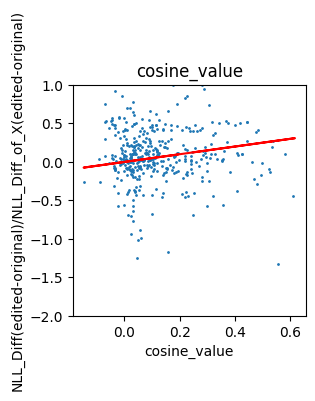

In [31]:
x = np.array([(one['cosine_value']) for one in over_all_results])
y = np.array([(min(one['NLL'])-min(one['orginal_NLL']))/(one['X_edited_NLL']-one['X_before_NLL']) for one in over_all_results])
# y = np.array([min(one['NLL']) for one in inner_product_results])
# y = np.array([one['NLL'][0]-min(one['orginal_NLL'] for one in inner_product_results])

plt.figure(figsize=(3,3))


# Perform linear regression: slope, intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the line of best fit
line = slope * x + intercept

plt.plot(x, line, color='red')

# Show the plot
plt.scatter(x,y,s=1)
plt.xlabel("cosine_value")  
plt.ylabel("NLL_Diff(edited-original)/NLL_Diff_of_X(edited-original)")
plt.ylim(-2,1)

plt.title(f"cosine_value")
plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/cosine_value.png")

In [22]:
over_all_results[0]['X_edited_NLL']

8.389169692993164